In [2]:
import numpy as np 

def group_faces(node_coords):
    x = [coord[0] for coord in node_coords.values()]
    y = [coord[1] for coord in node_coords.values()]
    z = [coord[2] for coord in node_coords.values()]

    group1 = {}  # fixed typo
    group2 = {}


    group1_threshold = 0.04 
    group2_threshold = -0.04
    tolerance = 0.00005

    for key , values in node_coords.items():
        if np.abs( values[0] - group1_threshold ) < tolerance:
            group1[key] = values 
        elif np.abs( values[0] - group2_threshold ) < tolerance: 
            group2[key] = values 

    groups = {}
    groups["group1"] = group1
    groups["group2"] = group2

    return groups 

def regroup_faces_4_plot(elements, nood_coords):
    faces = []
    for elem in elements:
            try:
                face1 = [nood_coords[nid] for nid in elem[:4]]
                face2 = [nood_coords[nid] for nid in elem[4:]]
                if len(face1) == 4:
                    faces.append(face1)
                if len(face2) == 4:
                    faces.append(face2)
            except KeyError as e:
                print(f'Warning: Node ID {e} not found. Skipping element.')
    return faces 


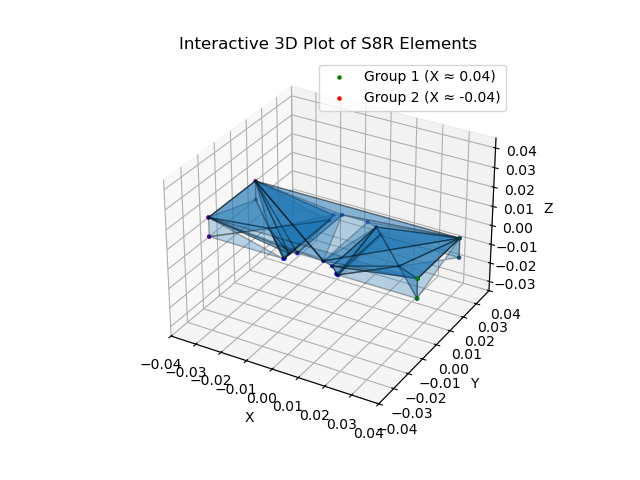

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

node_coords = {}
elements = []
plot_faces = True

# Step 1: Parse the .msh file
with open("Living_hinge_1.inp", "r") as file:
    in_node_section = False
    in_element_section = False
    for line in file:
        line = line.strip()
        if line.startswith("*NODE"):
            in_node_section = True
            in_element_section = False
            continue
        if line.startswith("*ELEMENT"):
            in_element_section = True
            in_node_section = False
            continue
        if line.startswith("*ELSET"):
            break
        if in_node_section:
            parts = line.split(",")
            if len(parts) >= 4:
                node_id = int(parts[0])
                x, y, z = map(float, parts[1:4])
                node_coords[node_id] = (x, y, z)
        if in_element_section and not line.startswith("*"):
            parts = [int(p) for p in line.split(",")]
            element_id = parts[0]
            node_ids = parts[1:]
            if len(node_ids) == 4:
                elements.append(node_ids)

grouped_faces = group_faces(node_coords)

# Step 2: Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
""
# Plot nodes
x = [coord[0] for coord in node_coords.values()]
y = [coord[1] for coord in node_coords.values()]
z = [coord[2] for coord in node_coords.values()]
ax.scatter(x, y, z, color='blue', s=5)

# Plot shell elements
if plot_faces:
    faces = regroup_faces_4_plot(elements, node_coords)
    poly = Poly3DCollection(faces, alpha=0.3, edgecolor='k')
    ax.add_collection3d(poly)


x_group1 = [coord[0] for coord in grouped_faces['group1'].values()]
y_group1 = [coord[1] for coord in grouped_faces['group1'].values()]
z_group1 = [coord[2] for coord in grouped_faces['group1'].values()]
ax.scatter(x_group1, y_group1, z_group1, color='green', s=5, label='Group 1 (X ≈ 0.04)')

x_group2 = [coord[0] for coord in grouped_faces['group2'].values()]
y_group2 = [coord[1] for coord in grouped_faces['group2'].values()]
z_group2 = [coord[2] for coord in grouped_faces['group2'].values()]
ax.scatter(x_group2, y_group2, z_group2, color='red', s=5, label='Group 2 (X ≈ -0.04)')

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Interactive 3D Plot of S8R Elements")
ax.legend()

# Equal aspect ratio
max_range = max(
    max(x) - min(x),
    max(y) - min(y),
    max(z) - min(z)
) / 2.0

mid_x = (max(x) + min(x)) / 2.0
mid_y = (max(y) + min(y)) / 2.0
mid_z = (max(z) + min(z)) / 2.0

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

In [4]:
print( grouped_faces["group1"] )

{9: (0.04, 0.015, 0.01), 10: (0.04, 0.015, 0.0), 17: (0.04, -0.015, 0.0), 18: (0.04, -0.015, 0.01)}


In [5]:
output_path = "upper.nam" ; 

i = 0 ; 
with open(output_path, 'w') as f:
    f.write("** Names based on upper\n")
    f.write("*NSET,NSET=Nupper\n")
    for key in grouped_faces["group1"]:
        i += 1
        if( i == len(grouped_faces["group1"])):
            f.write(f"  {key}")
        else:
            f.write(f"  {key},\n")

output_path = "lower.nam" ; 

i = 0 ; 
with open(output_path, 'w') as f:
    f.write("** Names based on upper\n")
    f.write("*NSET,NSET=Nlower\n")
    for key in grouped_faces["group2"]:
        i += 1
        if( i == len(grouped_faces["group2"])):
            f.write(f"  {key}")
        else:
            f.write(f"  {key},\n")